# Assignment 8

Develop a model for 20 news groups dataset from scikit-learn. Select 20% of data for test set.  

Develop metric learning model with siamese network [3 points] and triplet loss [3 points] (from seminar). 
Use KNN and LSH (any library for approximate nearest neighbor search) for final prediction after the network was trained. [2 points]

! Remember, that LSH gives you a set of neighbor candidates, for which you have to calculate distances to choose top-k nearest neighbors. 

Your quality metric = accuracy score [2 points if acc > 0.8 ]

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile

import nltk
from nltk import word_tokenize
nltk.download('punkt')

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from random import randrange, sample
from math import ceil
from tqdm import tqdm_notebook, tqdm
# I will use https://github.com/spotify/annoy library
!pip install annoy
from annoy import AnnoyIndex
from datetime import datetime

!pip install sentence_transformers
from sentence_transformers import SentenceTransformer


RANDOM_STATE = 42
DEVICE = 'cuda'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
X, y = fetch_20newsgroups('data', subset='all', return_X_y=True, random_state=RANDOM_STATE)

In [0]:
df = pd.DataFrame({'X': X, 'y': y})

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df.describe()

,y
count,18846.000000
mean,9.293166
std,5.562798
min,0.000000
25%,5.000000
50%,9.000000
75%,14.000000
max,19.000000


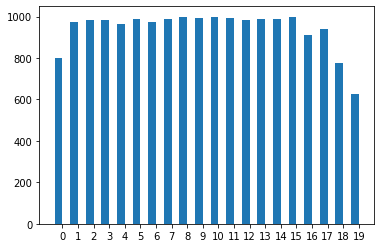

In [6]:
labels, values = zip(*sorted(Counter(df['y']).items()))
indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [7]:
model = SentenceTransformer('bert-large-nli-stsb-mean-tokens')

100%|██████████| 1.24G/1.24G [00:55<00:00, 22.5MB/s]


In [0]:
embeddings = model.encode(df['X'])

In [0]:
pd.options.mode.chained_assignment = None
df['embedding'] = tt.tensor(embeddings)

In [0]:
EMBED_SIZE = embeddings[0].shape[0]

In [11]:
EMBED_SIZE

1024

In [0]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [0]:
df_train, df_valid = train_test_split(df_train, test_size=0.05, random_state=RANDOM_STATE, shuffle=True)

In [0]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_valid = df_valid.sample(frac=1).reset_index(drop=True)

In [0]:
class_values = sorted(pd.unique(df['y']))

In [16]:
df_train.shape, df_test.shape, df_valid.shape

((14322, 3), (3770, 3), (754, 3))

In [0]:
batch_size = 32

In [0]:
REPLACE = False

def get_random_batch(df):
    rows = df.sample(batch_size)
    anchors = list(rows.embedding)
    classes = list(rows.y)
    while True:
        positive = []
        negative = []
        for i, class_ in enumerate(classes):
            positive_df = df[df['y'] == class_].sample(2, replace=REPLACE).reset_index(drop=True)
            if positive_df.embedding[0] == anchors[i]:
                positive.append(positive_df.embedding[1])
            else:
                positive.append(positive_df.embedding[0])
            negative_df = df[df['y'] != class_].sample(2, replace=REPLACE).reset_index(drop=True)
            if negative_df.embedding[0] == anchors[i]:
                negative.append(negative_df.embedding[1])
            else:
                negative.append(negative_df.embedding[0])
        yield tt.tensor(negative, requires_grad=True), tt.tensor(anchors, requires_grad=True), tt.tensor(positive, requires_grad=True)

In [0]:
train_iterator = get_random_batch(df_train)
valid_iterator = get_random_batch(df_valid)
test_iterator = get_random_batch(df_test)

In [0]:
def _train_epoch(model, iterator, optimizer, curr_epoch, n_batches=1000):
    model.train()
    running_loss = 0

    tqdm_range = tqdm_notebook(range(n_batches), total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)
    for i in tqdm_range:
        batch = next(iterator)
        optimizer.zero_grad()
        loss = model(batch)
        loss.backward()
        optimizer.step()
        curr_loss = loss.data.cpu().detach().item()
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss
        tqdm_range.set_postfix(loss='%.5f' % running_loss)

    return running_loss

In [0]:
def _test_epoch(model, iterator, n_batches=100):
    model.eval()
    epoch_loss = 0

    with tt.no_grad():
        for i in range(n_batches):
            batch = next(iterator)
            loss = model(batch)
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches

In [0]:
def nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=10, scheduler=None, early_stopping=2):
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, epoch)
        valid_loss = _test_epoch(model, valid_iterator)
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0
            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break
            prev_loss = min(prev_loss, valid_loss)

In [0]:
OUT_SIZE = 128

class SiameseNet(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.fc = nn.Linear(EMBED_SIZE, OUT_SIZE).to(DEVICE)


    def branch(self, x):
        return self.fc(x)


    def forward(self, batch):
        negative, anchor, positive = batch
        negative = self.branch(negative.to(DEVICE))
        anchor = self.branch(anchor.to(DEVICE))
        positive = self.branch(positive.to(DEVICE))
        loss = self.criterion(anchor, positive, negative)
        return loss

In [0]:
tt.cuda.empty_cache()

In [0]:
criterion = nn.TripletMarginLoss()
criterion = criterion.to(DEVICE)
model = SiameseNet(criterion).to(DEVICE)
optimizer = tt.optim.Adam(model.parameters())

In [232]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.57896


validation loss 0.59199


validation loss 0.61789


validation loss 0.58014


validation loss 0.59485


In [237]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=1, early_stopping=-1)

validation loss 0.60643


In [256]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.69294


validation loss 0.79607


validation loss 0.61633


validation loss 0.68041


validation loss 0.65482


In [260]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.74309


validation loss 0.79539


validation loss 0.65540


validation loss 0.72879


validation loss 0.75372


In [264]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.88482


validation loss 0.79890


validation loss 0.84356


validation loss 0.92512


validation loss 0.78904


In [268]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.85330


validation loss 0.81006


validation loss 0.88342


validation loss 0.79179


validation loss 0.78833


In [272]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.83110


validation loss 0.93034


validation loss 0.96865


validation loss 0.89703


validation loss 0.94055


In [276]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.85976


validation loss 0.88729


validation loss 0.86223


validation loss 0.86099


validation loss 0.91891


In [280]:
nn_train(model, train_iterator, valid_iterator, optimizer, n_epochs=5, early_stopping=-1)

validation loss 0.90097


validation loss 0.90753


validation loss 0.89455


validation loss 0.92166


validation loss 0.84997


In [0]:
K = 10  # K in KNN

def count_accuracy(df):
    TP = 0
    model.eval()
    with tt.no_grad():
        for i, (v, y) in enumerate(zip(df.embedding, df.y)):
            v = model.branch(tt.tensor(v).to(DEVICE))
            our_pred = t.get_nns_by_vector(v, K)
            ctr = Counter(df_train.y[our_pred])
            our_pred = ctr.most_common(1)[0][0]
            TP += (y == our_pred)
    return TP / df.shape[0]

In [0]:
t = AnnoyIndex(OUT_SIZE, "angular")  # Length of item vector that will be indexed

In [0]:
model.eval()
with tt.no_grad():
    for i, v in enumerate(df_train.embedding):
        v = tt.tensor(v).to(DEVICE)
        t.add_item(i, model.branch(v))
t.build(n_trees=15000)

In [259]:
# 1
count_accuracy(df_test)

0.7068965517241379

In [263]:
# 2
count_accuracy(df_test)

0.7137931034482758

In [267]:
# 3
count_accuracy(df_test)

0.7273209549071618

In [271]:
# 4
count_accuracy(df_test)

0.7220159151193634

In [275]:
# 5
count_accuracy(df_test)

0.7228116710875332

In [279]:
# 6
count_accuracy(df_test)

0.7275862068965517

In [283]:
# 7
count_accuracy(df_test)

0.7281167108753316